In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns

# hyperparameters turning
from ray import tune
from ray.tune.schedulers import ASHAScheduler

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

_TARGET_STK = 'MSFT'
pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False

In [2]:
from datetime import datetime
import yfinance as yfin

# Loading the data
stk_tickers = [_TARGET_STK, 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['VIXCLS', 'SP500', 'DJIA']

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)
# stk_data = web.get_data_yahoo(stk_tickers, start, end)
stk_data = yfin.download(stk_tickers, start, end).dropna()
ccy_data = web.DataReader(ccy_tickers, 'fred', start, end).dropna()
idx_data = web.DataReader(idx_tickers, 'fred', start, end).dropna()

print(stk_data)
print(ccy_data)
print(idx_data)

[*********************100%%**********************]  3 of 3 completed
             Adj Close                               Close              \
                 GOOGL         IBM        MSFT       GOOGL         IBM   
Date                                                                     
2014-01-02   27.855856  116.571358   31.290827   27.855856  177.370941   
2014-01-03   27.652653  117.268761   31.080303   27.652653  178.432129   
2014-01-06   27.960960  116.866684   30.423504   27.960960  177.820267   
2014-01-07   28.500000  119.197685   30.659283   28.500000  181.367111   
2014-01-08   28.559309  118.104424   30.111946   28.559309  179.703629   
...                ...         ...         ...         ...         ...   
2023-12-22  141.490005  162.139999  374.579987  141.490005  162.139999   
2023-12-26  141.520004  163.210007  374.660004  141.520004  163.210007   
2023-12-27  140.369995  163.460007  374.070007  140.369995  163.460007   
2023-12-28  140.229996  163.750000  375.279

In [3]:
import torch
time_str = datetime.now().strftime('%Y-%m-%d_%H.%M.%S')
return_period = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
validation_size = 0.2
seq_len = 5
num_layers = 10
hidden_size = 128
epoch_num=300
batch_size = 32
model_name=f"{_TARGET_STK}_V3_{time_str}.pt"

In [4]:

Y_raw = stk_data.loc[:, ('Adj Close', _TARGET_STK)].to_frame().pct_change(return_period).shift(-return_period).dropna().astype('float32')
Y_raw.columns = [f"{_TARGET_STK}_pred_{return_period}"]
# Y_raw.hist(bins=50)
# pyplot.show()
print(Y_raw.head())

            MSFT_pred_5
Date                   
2014-01-02    -0.043864
2014-01-03    -0.023571
2014-01-06    -0.031829
2014-01-07    -0.017303
2014-01-08     0.027964


In [5]:
def gen_analysis_data(stock_name):
    data = stk_data.xs(stock_name, axis=1, level=1)
    
    data = pd.concat([data.ta.percent_return(length=return_period, prefix=stock_name),
                      data.ta.adosc(prefix=stock_name),
                      data.ta.kvo(prefix=stock_name)], 
                      axis=1)
    data = data.dropna().astype('float32')
    return data

In [8]:
import pandas_ta as ta
Target_Data = gen_analysis_data(_TARGET_STK)
GOOGL_Data = gen_analysis_data('GOOGL')
IBM_Data = gen_analysis_data('IBM')
X1 = pd.concat([Target_Data, GOOGL_Data, IBM_Data], axis=1)
# X1.hist(bins=50)
# pyplot.show()
print(X1)

            MSFT_PCTRET_5  MSFT_ADOSC_3_10  MSFT_KVO_34_55_13  MSFT_KVOs_34_55_13  GOOGL_PCTRET_5  GOOGL_ADOSC_3_10  GOOGL_KVO_34_55_13  GOOGL_KVOs_34_55_13  IBM_PCTRET_5  IBM_ADOSC_3_10  IBM_KVO_34_55_13  IBM_KVOs_34_55_13
Date                                                                                                                                                                                                                           
2014-04-08      -0.038629      -24033148.0       2.112672e+06        5.627375e+06       -0.018491     -8.466605e+07       -1.149359e+07        -1.739002e+07     -0.006221   -1.626401e+06     280921.812500      625747.062500
2014-04-09      -0.021282      -12858371.0       2.615995e+06        5.197178e+06       -0.001898     -4.925304e+07       -9.422985e+06        -1.625188e+07      0.015965    8.868488e+04     368948.000000      589061.500000
2014-04-10      -0.040234      -16806242.0       1.496281e+06        4.668478e+06       -0.043412     -4

In [9]:
X2 = ccy_data.pct_change(return_period).dropna()
X2 = X2.rename(columns={ column : f"{column}_PCTRET_{return_period}" for column in X2.columns.to_list()})

X3 = pd.concat([idx_data['SP500'].pct_change(return_period), idx_data['DJIA'].pct_change(return_period)], axis=1)
X3 = X3.rename(columns={ column : f"{column}_PCTRET_{return_period}" for column in X3.columns.to_list()})
X3 = pd.concat([idx_data['VIXCLS'], X3], axis=1).dropna()

X = pd.concat([X1, X2, X3], axis=1).dropna()
features = X.columns.to_list()

print(X)

            MSFT_PCTRET_5  MSFT_ADOSC_3_10  MSFT_KVO_34_55_13  MSFT_KVOs_34_55_13  GOOGL_PCTRET_5  GOOGL_ADOSC_3_10  GOOGL_KVO_34_55_13  GOOGL_KVOs_34_55_13  IBM_PCTRET_5  IBM_ADOSC_3_10  IBM_KVO_34_55_13  IBM_KVOs_34_55_13  DEXJPUS_PCTRET_5  DEXUSUK_PCTRET_5  VIXCLS  SP500_PCTRET_5  DJIA_PCTRET_5
2014-04-08      -0.038629      -24033148.0       2.112672e+06        5.627375e+06       -0.018491     -8.466605e+07       -1.149359e+07        -1.739002e+07     -0.006221   -1.626401e+06     280921.812500      625747.062500         -0.013524          0.006250   14.89       -0.017799      -0.016723
2014-04-09      -0.021282      -12858371.0       2.615995e+06        5.197178e+06       -0.001898     -4.925304e+07       -9.422985e+06        -1.625188e+07      0.015965    8.868488e+04     368948.000000      589061.500000         -0.018975          0.007034   13.82       -0.009900      -0.008195
2014-04-10      -0.040234      -16806242.0       1.496281e+06        4.668478e+06       -0.043412     -

In [10]:
pd.set_option('display.precision', 5)
dataset = pd.concat([Y_raw, X], axis=1).dropna()
print(dataset.head(10))

X = dataset.loc[:, X.columns]
Y = dataset.loc[:, Y_raw.columns]


            MSFT_pred_5  MSFT_PCTRET_5  MSFT_ADOSC_3_10  MSFT_KVO_34_55_13  MSFT_KVOs_34_55_13  GOOGL_PCTRET_5  GOOGL_ADOSC_3_10  GOOGL_KVO_34_55_13  GOOGL_KVOs_34_55_13  IBM_PCTRET_5  IBM_ADOSC_3_10  IBM_KVO_34_55_13  IBM_KVOs_34_55_13  DEXJPUS_PCTRET_5  DEXUSUK_PCTRET_5  VIXCLS  SP500_PCTRET_5  DJIA_PCTRET_5
2014-04-08     -0.00176       -0.03863     -2.40331e+07        2.11267e+06          5627375.00        -0.01849      -8.46660e+07         -11493593.0          -17390024.0      -0.00622    -1.62640e+06      280921.81250       625747.06250          -0.01352           0.00625   14.89        -0.01780       -0.01672
2014-04-09     -0.00173       -0.02128     -1.28584e+07        2.61600e+06          5197178.00        -0.00190      -4.92530e+07          -9422985.0          -16251875.0       0.01596     8.86849e+04      368948.00000       589061.50000          -0.01898           0.00703   13.82        -0.00990       -0.00820
2014-04-10      0.01651       -0.04023     -1.68062e+07        1

In [16]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn_pandas import DataFrameMapper

train_size = int(len(X) * (1 - validation_size))
X_train = X.iloc[0:train_size].loc[:,features]
Y_train = Y.iloc[0:train_size]
X_test  = X.iloc[train_size - seq_len + 1:len(X)].loc[:, features]
Y_test  = Y.iloc[train_size - seq_len + 1:len(Y)]

X_dfm = DataFrameMapper(
    [ ([column], StandardScaler()) for column in X_train.columns.to_list()]
    , input_df=True, df_out=True)
X_train = X_dfm.fit_transform(X_train)
X_test = X_dfm.transform(X_test)
print(X_train)
print(X_test)

            MSFT_PCTRET_5  MSFT_ADOSC_3_10  MSFT_KVO_34_55_13  MSFT_KVOs_34_55_13  GOOGL_PCTRET_5  GOOGL_ADOSC_3_10  GOOGL_KVO_34_55_13  GOOGL_KVOs_34_55_13  IBM_PCTRET_5  IBM_ADOSC_3_10  IBM_KVO_34_55_13  IBM_KVOs_34_55_13  DEXJPUS_PCTRET_5  DEXUSUK_PCTRET_5   VIXCLS  SP500_PCTRET_5  DJIA_PCTRET_5
2014-04-08       -1.39272         -1.75763            1.23369             4.39787        -0.67624          -4.20584            -4.68110             -8.04102      -0.18066        -0.43084           0.85833            2.41734          -1.16033           0.49446 -0.33625        -0.93171       -0.82545
2014-04-09       -0.84882         -1.13207            1.53293             4.05788        -0.19268          -2.55882            -3.83277             -7.51111       0.50145         0.09609           1.12452            2.27610          -1.61662           0.55250 -0.47767        -0.57060       -0.45422
2014-04-10       -1.44305         -1.35307            0.86724             3.64005        -1.40250   

In [17]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
class LSTMDataSet(Dataset):
    def __init__(self, X, Y, seq_len):
        self.X = X
        self.Y = Y
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.X) - seq_len + 1
    
    def __getitem__(self, idx):
        return (torch.tensor(np.array(self.X[idx: idx + seq_len].loc[:, features]), dtype=torch.float32),
                torch.tensor(np.array(self.Y.iloc[idx + seq_len - 1,:]), dtype=torch.float32))

print(f"x:{X.shape}\nY:{Y.shape}\nX_train:{X_train.shape}\nY_train:{Y_train.shape}\nX_test:{X_test.shape}\nY_test:{Y_test.shape}")

train_loader = DataLoader(LSTMDataSet(X_train, Y_train, seq_len), batch_size=batch_size)
test_loader = DataLoader(LSTMDataSet(X_test, Y_test, seq_len), batch_size=batch_size)

x:(2416, 17)
Y:(2416, 1)
X_train:(1932, 17)
Y_train:(1932, 1)
X_test:(488, 17)
Y_test:(488, 1)


In [27]:
from torch import nn
class StockPricePredictionLSTM(nn.Module):
    def __init__(self, seq_len, input_size = len(features), hidden_size = hidden_size, num_layers=num_layers, num_fc_layers=1, activation_type=1):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        """
            input_size    : The number of expected features in the input x
            hidden_size   : The number of features in the hidden state h
            num_layers    : Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
            bias          : If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            batch_first   : If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
            dropout       : If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
            bidirectional : If True, becomes a bidirectional LSTM. Default: False
            proj_size     : If > 0, will use LSTM with projections of corresponding size. Default: 0
        """
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        layers = []
        in_features = self.hidden_size
        for i in range(1, num_fc_layers):
            out_features = int(in_features / 2)
            if (out_features <= 1):
                break
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU() if activation_type == 1 else
                          nn.Sigmoid()) if activation_type == 2 else nn.Tanh()
            in_features = out_features

        layers.append(nn.Linear(in_features, 1))
        self.fc = nn.Sequential(*layers)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            initrange = 0.5
            nn.init.uniform_(m.weight, -initrange, initrange)
            nn.init.zeros_(m.bias)
            print(f"{m.in_features},{m.out_features}")

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))

        fc_input = h_out[-1].view(-1, self.hidden_size)
        return self.fc(fc_input)


In [17]:
import math 
from sklearn.metrics import mean_squared_error

def eval_dl_method(model, dl, criterion=None, device=device):
    model.eval()
    y_gt = []
    y_pred = []
    vloss = 0.0
    for i, (x, y) in enumerate(dl):
        x = x.to(device)
        y = y.to(device)
        outputs = model(x)
        if criterion != None:
            vloss += criterion(outputs, y).item()
        # print(f"{i}:{vloss}")
        y_gt.extend(y.cpu().detach().numpy().reshape(-1))
        y_pred.extend(outputs.cpu().detach().numpy().reshape(-1))
    
    return (math.sqrt(mean_squared_error(y_gt, y_pred)), y_gt, y_pred, vloss / len(dl))

In [18]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

def train_dl_method(model, optimizer, dl, test_dl):    
    learning_rate = 0.01
    criterion = torch.nn.MSELoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    writer = SummaryWriter(f'runs/{_TARGET_STK}/{time_str}')    
    best_loss = 999999999    
    
    for epoch in tqdm(range(epoch_num)):
        # for i, (x, y) in enumerate(tqdm(dl, leave=False)):
        model.train()
        running_loss = 0.0
        for i, (x, y) in enumerate(dl):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model.state_dict(), model_name)

        with torch.no_grad():
            (testScore, test_y_gt, test_y_pred, running_vloss)  = eval_dl_method(model, test_dl, criterion)

        writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : running_loss / len(dl), 'Validation' : running_vloss },
                            epoch + 1)
        writer.flush()
        
        if epoch == 0 or (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}, loss = {loss.item(): .5f}")

    writer.add_hparams(
        {'return_period':return_period,
         'validation_size':validation_size,
         'seq_len':seq_len,
         'num_layers': num_layers,
         'hidden_size':hidden_size,
         'epoch_num':epoch_num,
         'batch_size':batch_size},
        {'Training':running_loss/len(dl),
         'Validation':running_vloss}
    )
    writer.close()

2024-01-18 06:49:33.404049: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-18 06:49:33.421564: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-18 06:49:33.516126: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 06:49:33.993298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [31]:
def train_LSTM(config):
    model = StockPricePredictionLSTM(seq_len, num_layers=config['num_layers'], hidden_size=config['hidden_size'],)
    model = model.to(device)
    model.train()
    train_dl_method(model, train_loader, test_loader)


SyntaxError: invalid syntax (1804061671.py, line 1)

In [26]:
search_space = {
    "seq_len": tune.grid_search([2,3,4,5]),
    "lr": tune.grid_search([0.001, 0.01, 0.1]),
    "momentum": tune.uniform(0.1, 0.9),
    "num_layers": tune.grid_search(1, 2, 4, 8),
    "hidden_size": tune.grid_search([8, 16, 32, 64, 128]),
    "num_fc_layers": tune.grid_search([1, 2, 3]),
    "activation_type": tune.grid_search([1, 2, 3])
}

analysis = tune.run(train_LSTM, config=search_space, resources_per_trial={'gpu':1})

SyntaxError: invalid syntax (2686099111.py, line 4)

In [20]:
from torch.utils.tensorboard import SummaryWriter
import io

def generate_predict_graph(y_pred):
    pred_pct_name = f'{_TARGET_STK}_pred_{return_period}'
    target_raw = stk_data.xs(_TARGET_STK, axis=1, level=1).iloc[train_size:]
    y_pred_df = Y_test.iloc[seq_len - 1:]
    y_pred_df[pred_pct_name] = y_pred
    cross_data = pd.concat([target_raw, y_pred_df], axis=1)
    cross_data['pred_price'] = (cross_data[pred_pct_name] + 1) * cross_data['Close']
    print(cross_data)
    cross_data['pred_price'] = cross_data.loc[:,['pred_price']].shift(return_period)
    cross_data[pred_pct_name] = cross_data.loc[:,[pred_pct_name]].shift(return_period)
    cross_data = cross_data.dropna()
    print(cross_data)
   
    pred_price_plot = np.empty_like(cross_data['pred_price'])
    target_price_plot = np.empty_like(cross_data['Close'])
    pred_price_plot[:] = cross_data['pred_price']
    target_price_plot[:] = cross_data['Close']
    figure = pyplot.figure()
    pyplot.plot(target_price_plot, label='Target Price')
    pyplot.plot(pred_price_plot, label='Predict Price')

    writer = SummaryWriter(f'runs/{_TARGET_STK}/{time_str}')
    writer.add_figure('Price', figure)
    
    writer.flush()
    writer.close()

    pyplot.plot(target_price_plot, label='Target Price')
    pyplot.plot(pred_price_plot, label='Predict Price')
    pyplot.legend()
    pyplot.show()


Train RMSE: 0.03
Test RMSE: 0.04
            Adj Close      Close       High        Low       Open    Volume  MSFT_pred_5  pred_price
2021-09-03  295.18228  301.14001  302.60001  300.26001  300.98999  14747900          NaN         NaN
2021-09-07  294.24127  300.17999  301.09000  298.20001  301.01001  17180400          NaN         NaN
2021-09-08  294.27069  300.20999  300.60999  297.47000  299.78000  15046800          NaN         NaN
2021-09-09  291.36923  297.25000  302.14001  297.00000  300.82001  19927000          NaN         NaN
2021-09-10  289.85971  295.70999  299.92001  295.38000  298.42001  19633400          NaN         NaN
2021-09-13  291.11441  296.98999  298.54001  294.07999  297.54999  23652900          NaN         NaN
2021-09-14  293.85901  299.79001  301.39001  298.10001  299.56000  21853400          NaN         NaN
2021-09-15  298.78946  304.82001  305.32001  301.82001  303.26001  28356300          NaN         NaN
2021-09-16  299.18155  305.22000  305.31000  300.76001  30

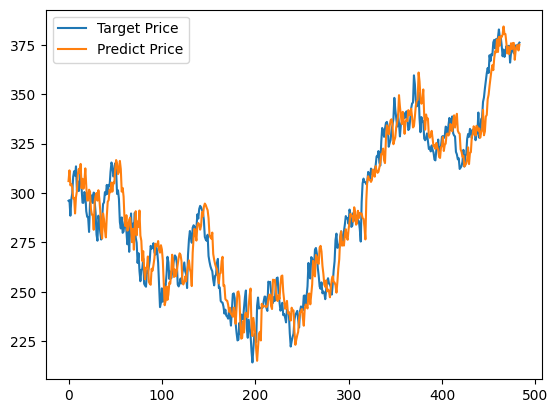

In [21]:
import math 
from sklearn.metrics import mean_squared_error

pd.set_option('display.precision', 5)

model = StockPricePredictionLSTM(seq_len, num_layers=num_layers, hidden_size=hidden_size)
model.load_state_dict(torch.load(model_name))
model.to(device)
model.eval()
(trainScore, train_y_gt, train_y_pred, _)= eval_dl_method(model, train_loader, device=device)
(testScore, test_y_gt, test_y_pred, _)  = eval_dl_method(model, test_loader, device=device)
# print(test_y_gt)
print(f"Train RMSE: {trainScore:.2f}\nTest RMSE: {testScore:.2f}")

writer = SummaryWriter(f'runs/{_TARGET_STK}/{time_str}')
writer.add_scalars('Training vs. Test RMSE', { 'Training' : trainScore, 'Test' : testScore }, 1)
writer.close()

generate_predict_graph(test_y_pred)